In [1]:
import numpy as np
import scipy
import struct
import os
import sklearn
from matplotlib.pylab import plt
import statistics
import math
import sys
import pandas as pd
from io import StringIO
from sklearn.preprocessing import StandardScaler

In [2]:
# load data from csv
df = pd.read_csv('./wine_dataset/wine_data.csv')
# filter out class 3 labels
df = df[df.label != 3]
df.head()

,label,feat_0,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,feat_10,feat_11,feat_12
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [3]:
len(df[df.label==2])

71

In [4]:
ITER = 200

In [5]:
# read data
data = df[df.columns[1:]]
label = df['label']
# convert into numpy 
data = data.values
label = label.values
label = np.reshape(label, (-1, 1))

# shuffle data
idx = np.random.permutation(label.shape[0])
data = data[idx]
label = label[idx]

# Normalize data
scaler = StandardScaler()
data = scaler.fit_transform(data)

In [6]:
# some utility function
def sigmoid(a):
    return 1/(1 + np.exp(-a))

def L1_norm(w):
    return sum(np.absolute(w))

def L2_norm(w):
    return sum(np.square(w))

def signum(w):
    return 1. if w>=0. else -1.

def cost_fun(X, y, w, lamb=None, norm=None):
    """
    X: a 2-D array - (n_samples, features)
    y: a 1-D array containing class labels
    w: parameters/weights
    
    cost = sum(ln(1 + e^(-y_i(wx_i))))
    """
    cost = 0
    
    for idx in range(0, X.shape[0]):
        cost += np.log(1/sigmoid(label[idx, 0]*np.dot(data[idx, :], w.T)))
        
    if norm=="L1":
        cost += (lamb*L1_norm(w))
    if norm=="L2":
        cost += (lamb*L2_norm(w))

    return float(cost)

In [7]:
# extending data dimension for handling bias - b
data = np.hstack((data, np.ones((data.shape[0], 1))))

In [8]:
state = -1
def pick_widx(w, mode):
    if mode=='random':
        w_idx = np.random.randint(0, len(w))
        return w_idx
    if mode=="round":
        global state
        if state < len(w)-1:
            state += 1
        else:
            state = 0
        return state

# Coordinate Gradient Descent

In [9]:
# Start model fitting
def fit_coordinate_descent(mode='round'):
    # initialize W
    w = [0.] * data.shape[1]
    w = np.asarray(w)
    cost = []
    for itr in range(0, ITER):
        # pick a random coordinate to optimize
        cost.append(cost_fun(data, label, w))
        
        def get_grad_by_idx(w_idx):
            grad = 0
            for idx in range(0, data.shape[0]):
                curr_d, curr_lb = data[idx, :], label[idx]
                # update w[w_idx] with computed gradient
                grad += -(curr_lb*curr_d[w_idx]) * (1-sigmoid(curr_lb*(np.dot(curr_d, w))))
                
            return grad
        
        if mode in ['round', 'random']:
            w_idx = pick_widx(w, mode)
            w[w_idx] = w[w_idx] - 0.01*get_grad_by_idx(w_idx)
            
        else:
            cost_ = []
            w_ = [w] * len(w)
            for idx in range(0, len(w)):
                w_[idx][idx] = w_[idx][idx] - (0.02*get_grad_by_idx(idx))
                cost_.append(cost_fun(data, label, w_[idx]))
        
            idx = cost_.index(min(cost_))
            w = w_[idx]
    print(w)
    return w, cost

In [10]:
w1, cost1 = fit_coordinate_descent("random")
w2, cost2 = fit_coordinate_descent("round")
w3, cost3 = fit_coordinate_descent("exhaustive")

[ 0.08896358  0.02500582  0.03539239 -0.07946394  0.06957936  0.06460812
  0.00619936 -0.0079022   0.01249009  0.25241446  0.01249971  0.07246605
  0.01367679  2.58117416]
[ 0.1168137   0.02589807  0.05908703 -0.07697936  0.04077491  0.03453562
  0.06356415 -0.01783837 -0.01808621  0.11079166  0.00304994  0.03948249
  0.1367922   2.53221583]
[ 0.28278735  0.09158593  0.2035453  -0.23177116  0.06718387  0.02732452
  0.11314267 -0.01325699 -0.07463719  0.25852421  0.02314908  0.17887301
  0.45520915  5.05615071]


# K-Sparse Coordinate Gradient Descent

In [11]:
# Start model fitting for 
def fit_sparse_coordinate_descent(lamb, norm):
    # initialize W
    #w = np.random.rand(14)
    w = [0.] * data.shape[1]
    w = np.asarray(w)
    cost = []
    for itr in range(0, ITER):
        # pick a coordinate adaptively
        cost.append(cost_fun(data, label, w, lamb, norm))
        
        def get_grad_by_idx(w_idx):
            grad = 0
            for idx in range(0, data.shape[0]):
                curr_d, curr_lb = data[idx, :], label[idx]
                # update w[w_idx] with computed gradient
                grad += -(curr_lb*curr_d[w_idx]) * (1-sigmoid(curr_lb*(np.dot(curr_d, w))))
                
            if norm=="L1":
                grad += (lamb*signum(w[w_idx]))
            if norm=="L2":
                grad += (2*lamb*w[w_idx])
                
            return grad

        cost_ = []
        w_ = [w] * len(w)
        for idx in range(0, len(w)):
            w_[idx][idx] = w_[idx][idx] - (0.02*get_grad_by_idx(idx))
            cost_.append(cost_fun(data, label, w_[idx], lamb, norm))

        idx = cost_.index(min(cost_))
        w = w_[idx]

    print(w)
    return w, cost

In [12]:
w4, cost4 = fit_sparse_coordinate_descent(lamb=2., norm="L1")
w5, cost5 = fit_sparse_coordinate_descent(lamb=2., norm="L2")

[ 0.0252605  -0.01808808  0.00940722 -0.04381186  0.04300848 -0.01836778
  0.03138884  0.01354168 -0.01372444  0.05403706 -0.0036646   0.04012893
  0.03776355  3.34637136]
[ 0.1158173   0.02220471  0.0642281  -0.07630912  0.01260581  0.00720505
  0.02780289 -0.00589894 -0.00875101  0.06159012  0.00259249  0.04932121
  0.13675391  2.11698999]


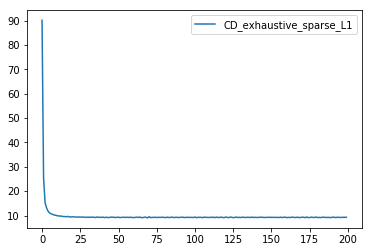

In [13]:
plt.plot(range(len(cost4)), cost4, label="CD_exhaustive_sparse_L1")
#plt.plot(range(len(cost5)), cost5, label="CD_exhaustive_sparse_L2")
plt.legend()

In [19]:
# Choose K-sparse
def choose_top_k(k, w):
    w_ = np.sort(np.absolute(w))
    item = list(w_[-k:])
    w_ = np.zeros(14)
    for idx in range(0, len(w)):
        if w[idx] in item or -w[idx] in item:
            w_[idx] = w[idx]

    return w_
  
def plot_k_curve(w):
    cost = []
    for k in range(0, data.shape[1]):
        cost.append(cost_fun(data, label, choose_top_k(k+1, w)))
    
    plt.figure()
    plt.plot(range(len(cost)), cost, label="CD Exhaustive L1")
    plt.xlabel('Value of K')
    plt.ylabel('Loss')
    plt.title('Coordinate Descent with L1 Regularizer')
    plt.grid(True)
    plt.legend()
    plt.savefig('l1versusk.png', format='png', dpi=300)

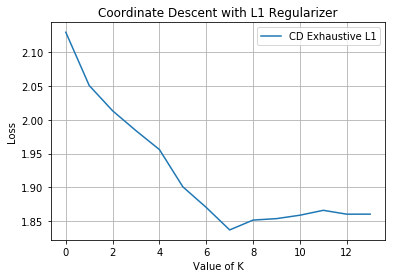

In [20]:
plot_k_curve(w4)

# Gradient Descent

In [16]:
# Start model fitting for 
def fit_gradient_descent():
    # initialize W
    w = [0.] * data.shape[1]
    w = np.asarray(w)
    cost = []
    for itr in range(0, ITER):
        # pick a coordinate adaptively
        cost.append(cost_fun(data, label, w))
        
        def get_grad_by_idx(w_idx):
            grad = 0
            for idx in range(0, data.shape[0]):
                curr_d, curr_lb = data[idx, :], label[idx]
                # update w[w_idx] with computed gradient
                grad += -(curr_lb*curr_d[w_idx]) * (1-sigmoid(curr_lb*(np.dot(curr_d, w))))
                
            return grad
    
        for idx in range(0, len(w)):
            w[idx] = w[idx] - (0.01*get_grad_by_idx(idx))

    print(w)
    return cost

In [17]:
cost6 = fit_gradient_descent()

[ 0.31724424  0.06841889  0.18038142 -0.19643803  0.050703    0.02552257
  0.09591075 -0.02092156 -0.04278448  0.17691867  0.02026169  0.13756965
  0.37627983  4.50947199]


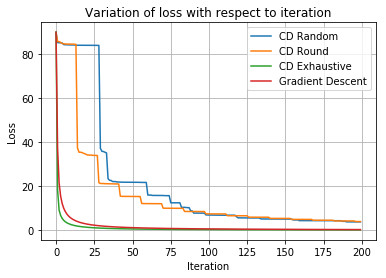

In [18]:
plt.figure()
plt.plot(range(len(cost1)), cost1, label="CD Random")
plt.plot(range(len(cost2)), cost2, label="CD Round")
plt.plot(range(len(cost3)), cost3, label="CD Exhaustive")
plt.plot(range(len(cost6)), cost6, label="Gradient Descent")
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Variation of loss with respect to iteration')
plt.grid(True)
plt.legend()
plt.savefig('losscurve.png', format='png', dpi=300)